In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from config import opt
import models
import joblib
import torch
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
test_data = pd.read_csv('./raw_data/test_data.csv')

In [3]:
test_data['date'] = pd.to_datetime(test_data['date'])

In [4]:
test_data = test_data.set_index('date')

In [5]:
data_utility = joblib.load('./data_utility.pkl')

In [6]:
feature_columns = data_utility.get_feature_columns()

In [7]:
feature_index = data_utility.get_feature_index()

In [8]:
model = models.DTCN(feature_columns=feature_columns,feature_index=feature_index,
                    dnn_hidden_units=opt.dnn_hidden_units,window_size=opt.WINDOW_SIZE,
                    output_size=opt.out_size,residual_size=opt.residual_size,
                    skip_size=opt.skip_size,dilation_cycles=opt.dilation_cycles,
                    dilation_depth=opt.dilation_depth)

In [9]:
model.load('./models/checkpoints/DTCN19.pth')

In [15]:
def predict(data,history_time,data_utility,opt,model):
    history_data = data[history_time[0]:history_time[1]].copy()
    history_data.reset_index(inplace=True,drop=True)
    scaler = data_utility.get_scaler()
    lbes = data_utility.get_lbes()
    history_data[opt.dense_features] = scaler.transform(history_data[opt.dense_features])
    for feat in opt.sparse_features:
        history_data[feat] = lbes[feat].transform(history_data[feat])
    history_data = data_utility.build_dataset(history_data)
    print("下一时刻预测:")
    
    true_label = history_data[96:,-1]
    trues = np.zeros([48,5])
    trues[:,-1]=true_label
    true_label = scaler.inverse_transform(trues)[:,-1]
    
    pred_label = []
    with torch.no_grad():
        model.eval()
        for i in range(48):
            inputs = torch.from_numpy(history_data[i:i+96]).unsqueeze(0)
            inputs = inputs.type(torch.FloatTensor)
            pred = model(inputs)
            pred_label.append(pred[-1,-1,-1].item())
    
    preds = np.zeros([48,5])
    preds[:,-1]=pred_label
    pred_label = scaler.inverse_transform(preds)[:,-1]
    
    mape = (np.abs(pred_label-true_label)/true_label).mean()*100
    print("下一时刻预测误差：",mape)
    
    plt.title("下一时刻预测负荷图")
    plt.plot(true_label,c='r',label='true')
    plt.plot(pred_label,c='b',label='pred')
    plt.legend(loc='best')
    plt.show()
    
    rol_history_data = history_data.copy()
    rol_preds_label = []
    with torch.no_grad():
        model.eval()
        for i in range(48):
            inputs = torch.from_numpy(rol_history_data[i:i+96]).unsqueeze(0)
            inputs = inputs.type(torch.FloatTensor)
            pred = model(inputs)
            rol_preds_label.append(pred[-1,-1,-1].item())
            rol_history_data[i+96,-1] = pred[-1,-1,-1].item()
    
    rol_preds = np.zeros([48,5])
    rol_preds[:,-1]=rol_preds_label
    rol_preds_label = scaler.inverse_transform(rol_preds)[:,-1]
    
    rol_mape = (np.abs(rol_preds_label-true_label)/true_label).mean()*100
    print("一日滚动预测误差：",rol_mape)
    
    plt.title("一日滚动预测负荷图")
    plt.plot(true_label,c='r',label='true')
    plt.plot(rol_preds_label,c='b',label='pred')
    plt.legend(loc='best')
    plt.show()

下一时刻预测:
下一时刻预测误差： 0.560828392844845


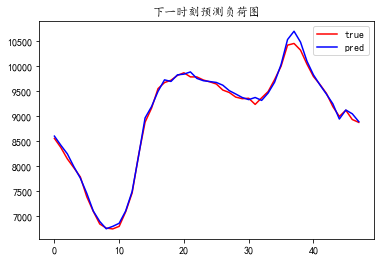

一日滚动预测误差： 5.456844726785928


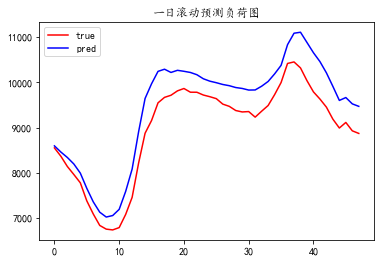

In [19]:
predict(test_data,['2010-9-01','2010-9-03'],data_utility,opt,model)